In [102]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
import xgboost as xgb
from PIL import Image
import cv2
import os
import random
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

seed_everything(42)

In [4]:
os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images')
data = pd.read_csv('data.csv')
data.head()

,images,labels
0,20130529_01_Driv_001_f .jpg,0
1,20130529_01_Driv_002_f .jpg,0
2,20130529_01_Driv_003_f .jpg,0
3,20130529_01_Driv_004_f .jpg,0
4,20130529_01_Driv_005_f .jpg,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], 
                                                    test_size = 0.2, stratify= data['labels'],
                                                    random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(484,)
(484,)
(122,)
(122,)


In [23]:
def preproc_images(image_paths, label_images, target_size = (80,80)):
    images = []
    labels = []
    idx = 0
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img_resized = img.resize(target_size)
            #img_gray = img_resized.convert('L')
            img_array = np.array(img_resized) / 255.0
            images.append(img_array)
            labels.append(label_images[idx])
        idx += 1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images\\DrivImages')
train_images, train_labels = preproc_images(list(X_train), list(y_train))
test_images, test_labels = preproc_images(list(X_test), list(y_test))

In [24]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
)

labels_to_augment = [1, 2]

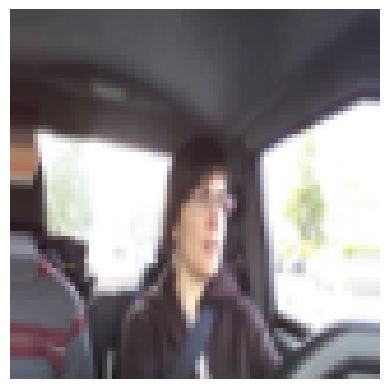

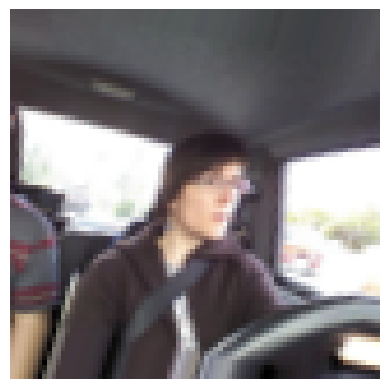

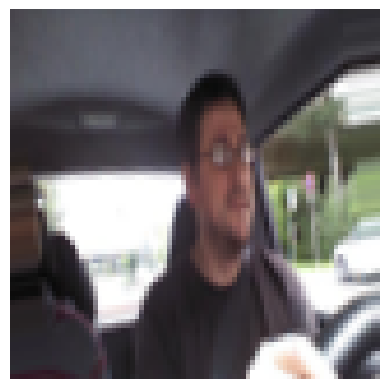

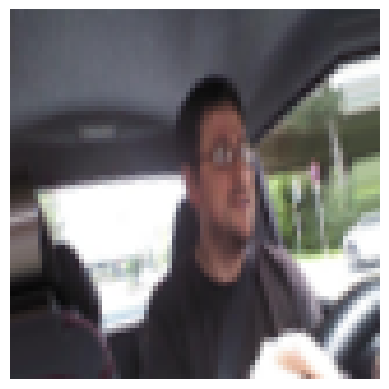

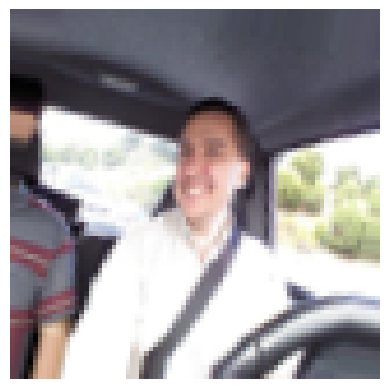

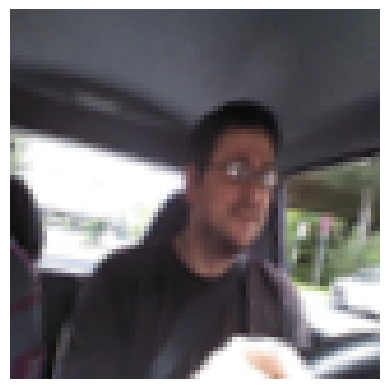

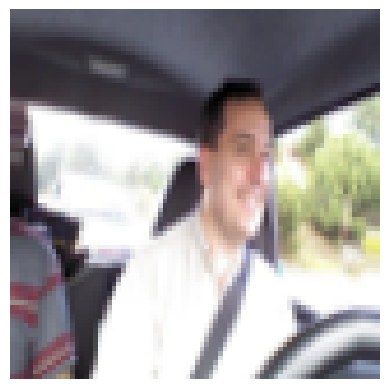

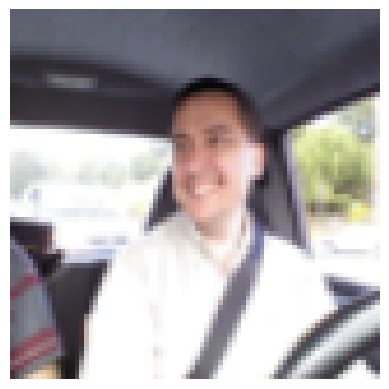

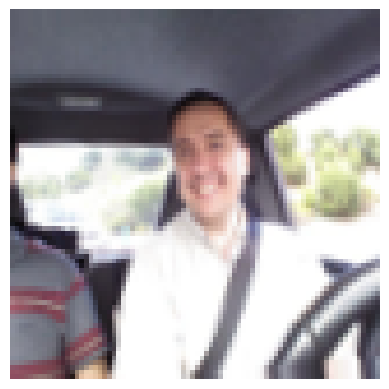

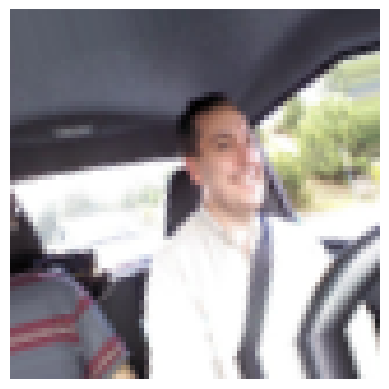

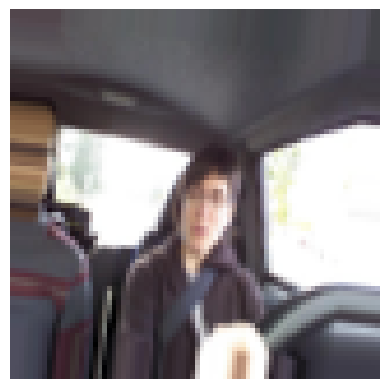

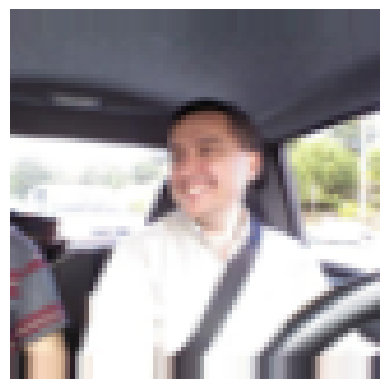

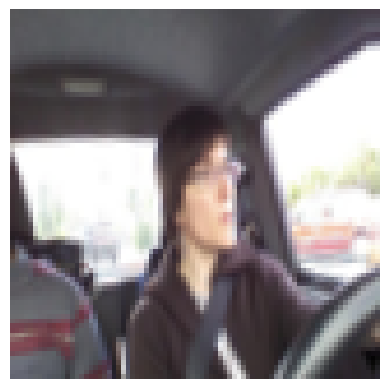

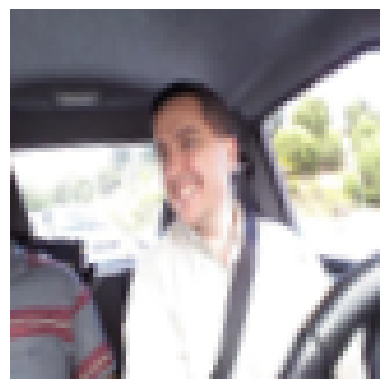

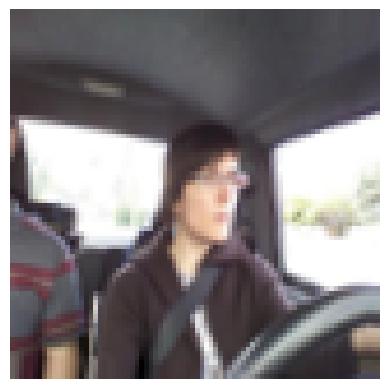

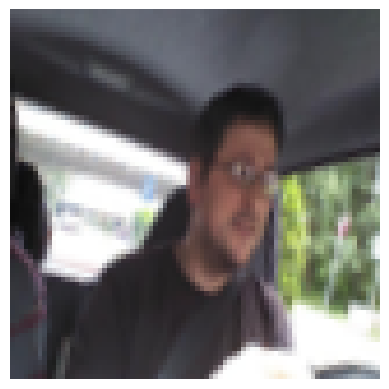

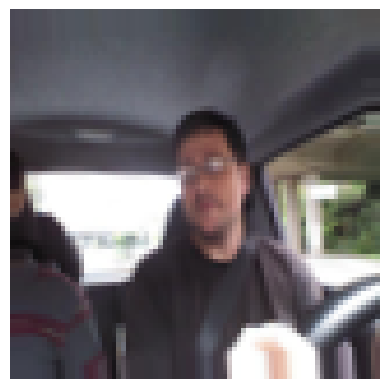

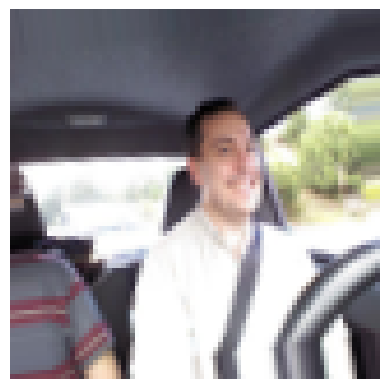

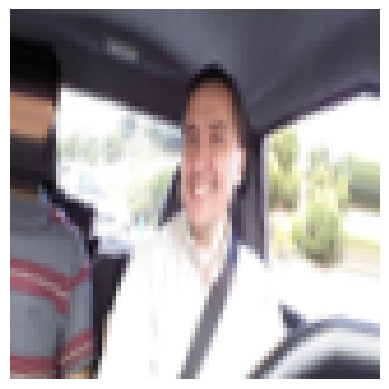

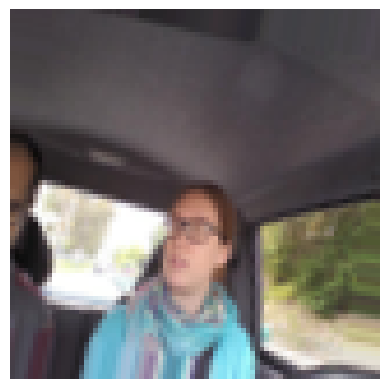

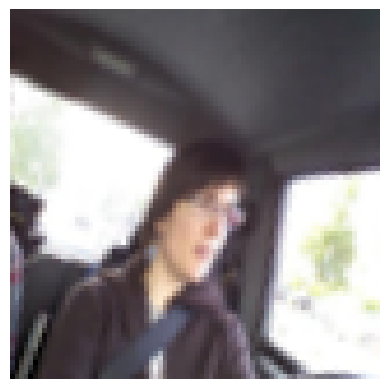

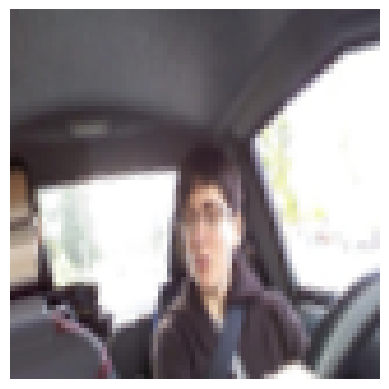

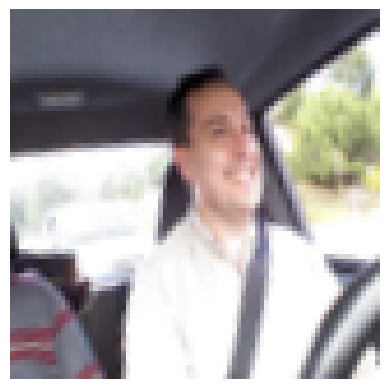

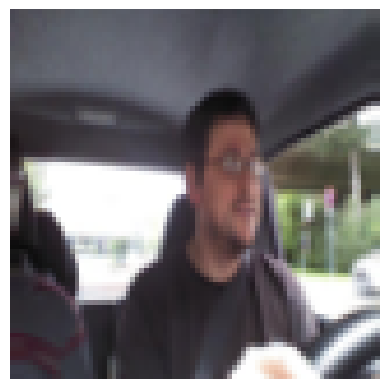

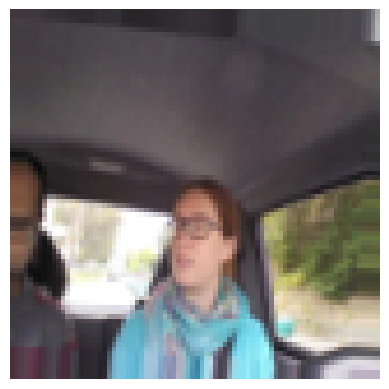

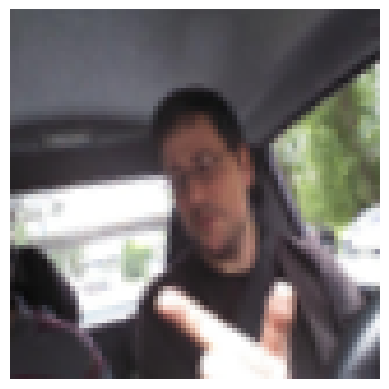

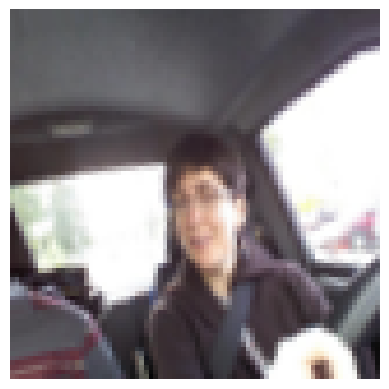

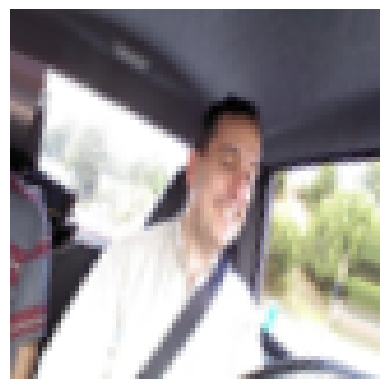

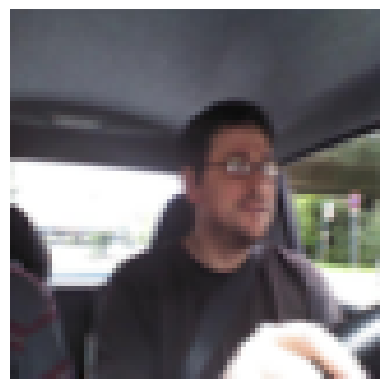

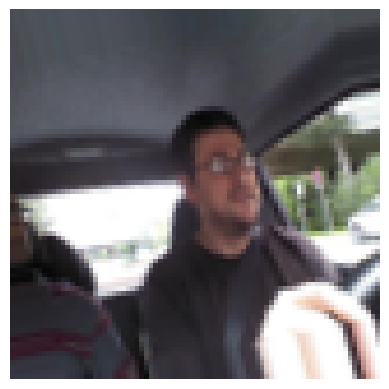

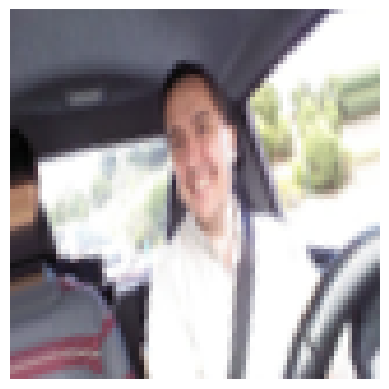

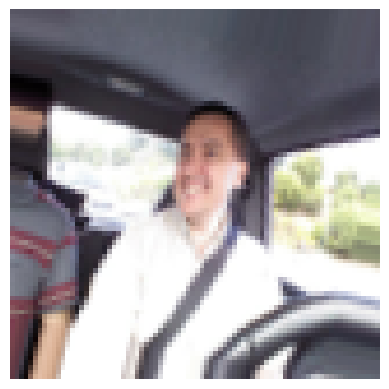

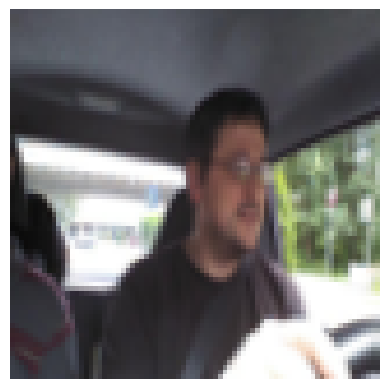

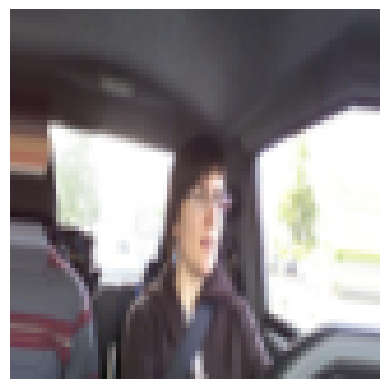

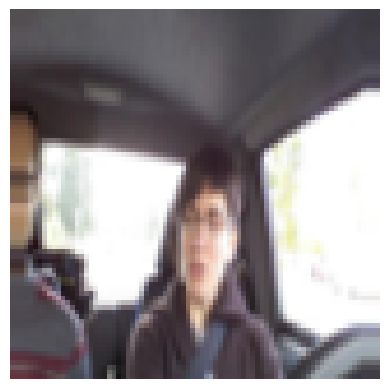

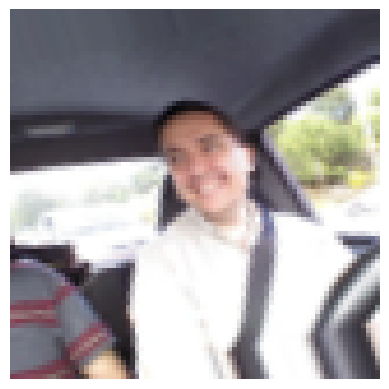

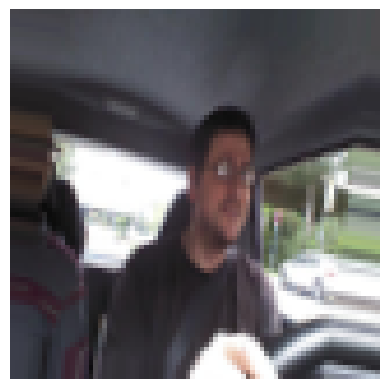

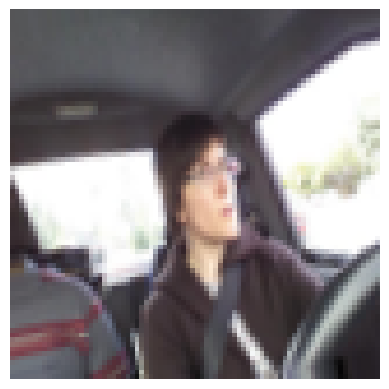

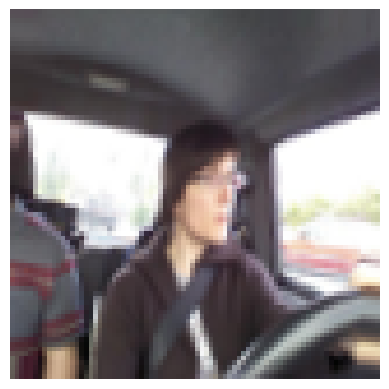

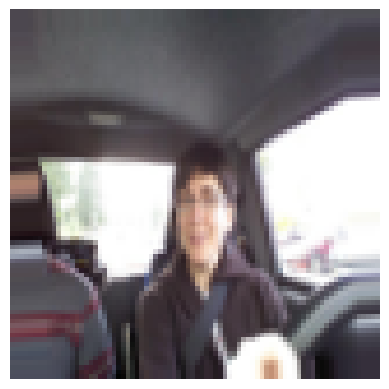

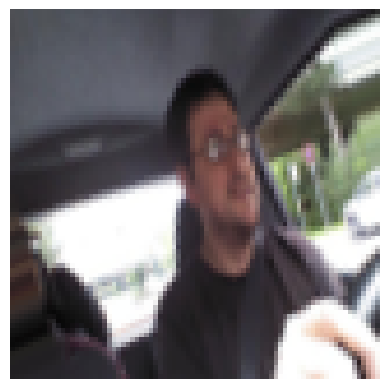

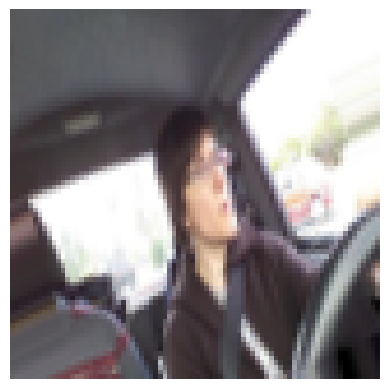

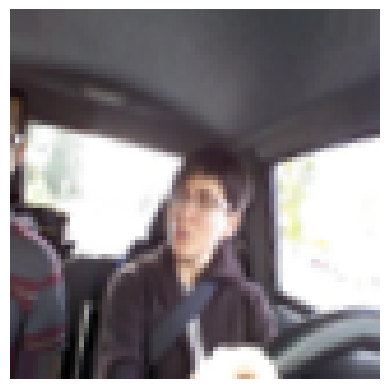

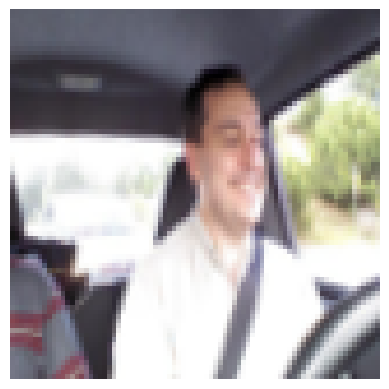

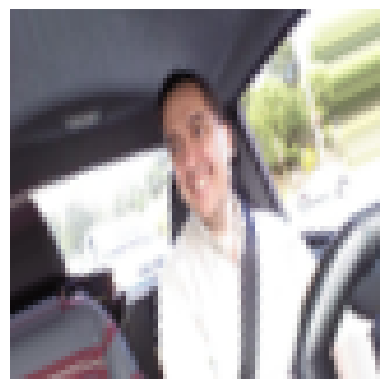

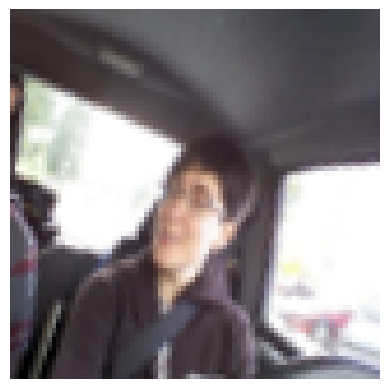

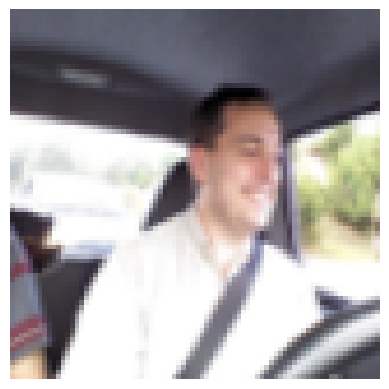

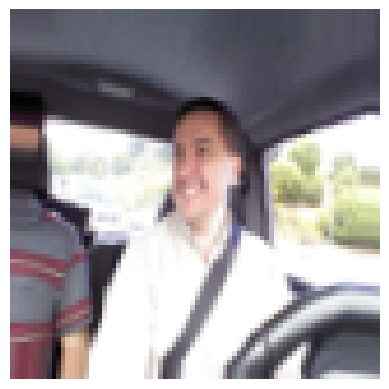

In [25]:
augmented_train_images = []
augmented_train_labels = []

augmentations_per_image = 18


for img, label in zip(train_images, train_labels):
    if label in labels_to_augment:
        img = img.reshape((1,) + img.shape)
        idx = 0
        augment = data_gen.flow(img, batch_size = 1)
        for batch in augment:
            augmented_image = batch[0]
            augmented_train_images.append(augmented_image)
            augmented_train_labels.append(label)
            idx += 1

            if idx == 5:
                plt.imshow(augmented_image, cmap='gray')
                plt.axis('off') 
                plt.show()

            if idx >= augmentations_per_image:
                break
            
    else:
        augmented_train_images.append(img)
        augmented_train_labels.append(label)


augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

In [26]:
augmented_train_images_reshaped = augmented_train_images.reshape(augmented_train_images.shape[0], -1)
test_images_reshaped = test_images.reshape(test_images.shape[0], -1)
print(augmented_train_images_reshaped.shape)
print(test_images_reshaped.shape)

(1300, 19200)
(122, 19200)


We can also apply PCA to our data and fit popular machine learning models to the reduced dimension images.
Furthermore, we can compare them with the same classifiers fit on the original, non-reduced dim images.

In [27]:
scaler = StandardScaler()
train_images_scaled = scaler.fit_transform(augmented_train_images_reshaped)
test_images_scaled = scaler.transform(test_images_reshaped)

In [28]:
pca = PCA()
pca.fit(augmented_train_images_reshaped)

PCA()

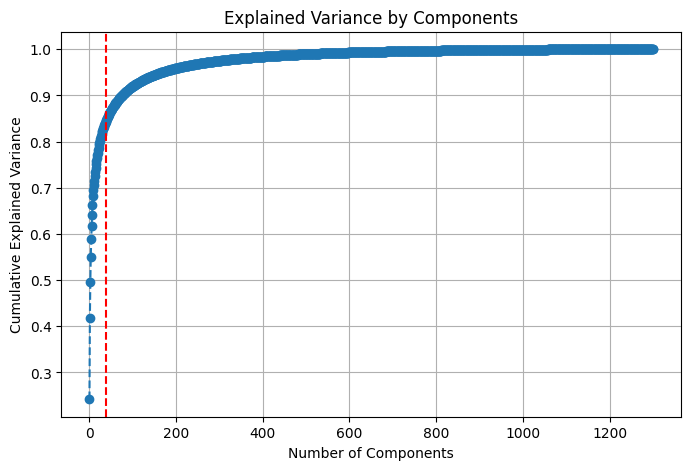

In [82]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=40, color='r', linestyle='--')

plt.grid(True)
plt.show()

From the ELBOW plot, we see that we need to retain only about 40 of the Principal components

In [83]:
pca_optimal = PCA(n_components=40)
train_images_pca = pca_optimal.fit_transform(train_images_scaled)
test_images_pca = pca_optimal.transform(test_images_scaled)

print(train_images_pca.shape)
print(test_images_pca.shape)

(1300, 40)
(122, 40)


We can visualize one of the images we applied PCA on

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


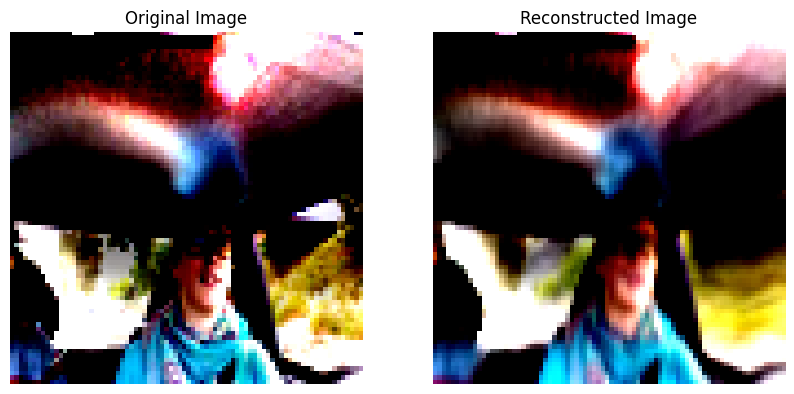

In [84]:
images_reconstructed = pca_optimal.inverse_transform(train_images_pca[0])
image_reconstructed_reshaped = images_reconstructed.reshape((80,80,3))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(train_images_scaled[0].reshape((80,80,3)), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(image_reconstructed_reshaped, cmap='gray')
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

plt.show()

Now given our PCA data, we can fit the original models we fit on them.

## LDA

In [85]:
lda = LDA()
lda.fit(train_images_pca, augmented_train_labels)

LinearDiscriminantAnalysis()

In [86]:
y_pred_train = lda.predict(train_images_pca)
y_pred_test = lda.predict(test_images_pca)

In [87]:
train_acc = accuracy_score(augmented_train_labels,y_pred_train)
test_acc = accuracy_score(test_labels,y_pred_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 93.46%
Test Accuracy: 90.98%


## QDA

In [88]:
qda = QDA()
qda.fit(train_images_pca, augmented_train_labels)

QuadraticDiscriminantAnalysis()

In [89]:
y_pred_train = qda.predict(train_images_pca)
y_pred_test = qda.predict(test_images_pca)

In [90]:
train_acc = accuracy_score(augmented_train_labels,y_pred_train)
test_acc = accuracy_score(test_labels,y_pred_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 99.46%
Test Accuracy: 93.44%


## SVM

### Linear Kernel

In [93]:
svm_linear_classifier = SVC(kernel='linear')
svm_linear_classifier.fit(train_images_pca, augmented_train_labels)

y_pred_train_svm = svm_linear_classifier.predict(train_images_pca)
y_pred_test_svm = svm_linear_classifier.predict(test_images_pca)

train_acc = accuracy_score(augmented_train_labels,y_pred_train_svm)
test_acc = accuracy_score(test_labels,y_pred_test_svm)


print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 99.92%
Test Accuracy: 92.62%


### Polynomial Kernel

In [96]:
svm_poly_classifier = SVC(kernel='poly')
svm_poly_classifier.fit(train_images_pca, augmented_train_labels)

y_pred_train_svm = svm_poly_classifier.predict(train_images_pca)
y_pred_test_svm = svm_poly_classifier.predict(test_images_pca)

train_acc = accuracy_score(augmented_train_labels,y_pred_train_svm)
test_acc = accuracy_score(test_labels,y_pred_test_svm)


print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 99.38%
Test Accuracy: 91.80%


### RBF

In [97]:
svm_rbf_classifier = SVC(kernel='rbf')
svm_rbf_classifier.fit(train_images_pca, augmented_train_labels)

y_pred_train_svm = svm_rbf_classifier.predict(train_images_pca)
y_pred_test_svm = svm_rbf_classifier.predict(test_images_pca)

train_acc = accuracy_score(augmented_train_labels,y_pred_train_svm)
test_acc = accuracy_score(test_labels,y_pred_test_svm)


print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 99.46%
Test Accuracy: 91.80%


## XGB

In [103]:
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_classifier.fit(train_images_pca, augmented_train_labels)

y_pred_train_svm = xgb_classifier.predict(train_images_pca)
y_pred_test_svm = xgb_classifier.predict(test_images_pca)

train_acc = accuracy_score(augmented_train_labels,y_pred_train_svm)
test_acc = accuracy_score(test_labels,y_pred_test_svm)


print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 94.26%


## Neural Network

## CNN